# Bagging

Let's implement some bagged LGBM models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from tqdm.notebook import trange, tqdm

### USE FOR LOCAL JUPYTER NOTEBOOKS ###
DOWNLOAD_DIR = Path('../download')
DATA_DIR = Path('../data')
SUBMISSIONS_DIR = Path('../submissions')
MODEL_DIR = Path('../models')
#######################################

##### GOOGLE COLAB ######
# DOWNLOAD_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/earthquake_damage_competition/download')
# SUBMISSIONS_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/earthquake_damage_competition/submissions')
# DATA_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/earthquake_damage_competition/data')
# MODEL_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/earthquake_damage_competition/model')
########################

X = pd.read_csv(DOWNLOAD_DIR / 'train_values.csv', index_col='building_id')
categorical_columns = X.select_dtypes(include='object').columns
bool_columns = [col for col in X.columns if col.startswith('has')]

X_test = pd.read_csv(DOWNLOAD_DIR / 'test_values.csv', index_col='building_id')
y = pd.read_csv(DOWNLOAD_DIR / 'train_labels.csv', index_col='building_id')

In [2]:
sns.set()

[This](https://stackoverflow.com/questions/49606886/installing-gpu-support-for-lightgbm-on-google-collab) answer seems to show how to install LGBM for GPU on Google Colab.

In [3]:
! pip uninstall lightgbm

Uninstalling lightgbm-3.1.1.99:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/lightgbm
    /usr/local/lib/python3.7/dist-packages/lightgbm-3.1.1.99-py3.7.egg-info
Proceed (y/n)? y
  Successfully uninstalled lightgbm-3.1.1.99


In [5]:
!pip install lightgbm --install-option=--gpu

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [6]:
pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [4]:
# Google Colab only
! git clone --recursive https://github.com/Microsoft/LightGBM

fatal: destination path 'LightGBM' already exists and is not an empty directory.


In [4]:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;    

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: theadammurphy (use `wandb login --relogin` to force relogin)


True

In [4]:
run = wandb.init(project='earthquake_damage_competition')

wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
X_test.shape

(86868, 38)

In [6]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

label_enc = LabelEncoder()

t = [('ord_encoder', OrdinalEncoder(dtype=int), categorical_columns)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')

In [7]:
X_all_ints = ct.fit_transform(X)
y = label_enc.fit_transform(np.ravel(y))

In [8]:
# Note that append for pandas objects works differently to append with
# python objects e.g. python append modifes the list in-place
# pandas append returns a new object, leaving the original unmodified
not_categorical_columns = X.select_dtypes(exclude='object').columns
cols_ordered_after_ordinal_encoding = categorical_columns.append(not_categorical_columns)

In [9]:
geo_cols = pd.Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'])
cat_cols_plus_geo = categorical_columns.append(geo_cols)

In [10]:
train_data = lgb.Dataset(X_all_ints,
                        label=y,
                        feature_name=list(cols_ordered_after_ordinal_encoding),
                        categorical_feature=list(cat_cols_plus_geo))

In [11]:
# Taken from the docs for lgb.train and lgb.cv
# Helpful Stackoverflow answer: 
# https://stackoverflow.com/questions/50931168/f1-score-metric-in-lightgbm
from sklearn.metrics import f1_score

def get_ith_pred(preds, i, num_data, num_class):
    """
    preds: 1D NumPY array
        A 1D numpy array containing predicted probabilities. Has shape
        (num_data * num_class,). So, For binary classification with 
        100 rows of data in your training set, preds is shape (200,), 
        i.e. (100 * 2,).
    i: int
        The row/sample in your training data you wish to calculate
        the prediction for.
    num_data: int
        The number of rows/samples in your training data
    num_class: int
        The number of classes in your classification task.
        Must be greater than 2.
    
    
    LightGBM docs tell us that to get the probability of class 0 for 
    the 5th row of the dataset we do preds[0 * num_data + 5].
    For class 1 prediction of 7th row, do preds[1 * num_data + 7].
    
    sklearn's f1_score(y_true, y_pred) expects y_pred to be of the form
    [0, 1, 1, 1, 1, 0...] and not probabilities.
    
    This function translates preds into the form sklearn's f1_score 
    understands.
    """
    # Does not work for binary classification, preds has a different form
    # in that case
    assert num_class > 2
    
    preds_for_ith_row = [preds[class_label * num_data + i]
                        for class_label in range(num_class)]
    
    # The element with the highest probability is predicted
    return np.argmax(preds_for_ith_row)
    
def lgb_f1_micro(preds, train_data):
    y_true = train_data.get_label()
    
    num_data = len(y_true)
    num_class = 3
    
    y_pred = []
    for i in range(num_data):
        ith_pred = get_ith_pred(preds, i, num_data, num_class)
        y_pred.append(ith_pred)
    
    return 'f1', f1_score(y_true, y_pred, average='micro'), True

In [ ]:
param = {'num_leaves': 120,
         'min_child_samples': 40,
         'learning_rate': 0.2,
         'boosting_type': 'goss',
         'objective': 'multiclass',
         'num_class': 3,
         'verbosity': -1,
         'num_threads': 8,
         'seed': 1}

bags = 50
bagged_prediction = np.zeros(X_test.shape[0])

for n in range(bags):
    print(f'Bag: {n}')
    param['seed'] += n
    booster = lgb.train(param,
                        train_data,
                        30,
                        categorical_feature=list(cat_cols_plus_geo),
                        feval=lgb_f1_micro)
    
    prob_preds = booster.predict(ct.transform(X_test))
    preds = [np.argmax(p) + 1 for p in prob_preds]
    bagged_prediction += preds

Bag: 0
Bag: 1
Bag: 2
Bag: 3
Bag: 4
Bag: 5
Bag: 6
Bag: 7
Bag: 8
Bag: 9


How am I supposed to know if this model is better without testing it beforehand? Let's just make a model and submit it and see what the score is first and then worry about more submissions after. If I have a range of submissions I want to try, I can just build them up and submit new ones each day. I can even create a list of those I want to submit

In [ ]:
np.unique(bagged_prediction / 10)

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ])

In [ ]:
bagged_prediction /= 10

In [ ]:
rounded_preds = [int(round(pred)) for pred in bagged_prediction]

In [ ]:
sub_format = pd.read_csv(DOWNLOAD_DIR / 'submission_format.csv',
                         index_col='building_id')

my_sub = pd.DataFrame(data=rounded_preds,
                      columns=sub_format.columns,
                      index=sub_format.index)

title = '03-09 - LGBM API - lgbm_02_02 hyperparams - 10 bags, 30 rounds'

my_sub.to_csv(SUBMISSIONS_DIR / f'{title}.csv')

Woo jumped to 0.7469 
From 228 to 167

In [ ]:
def build_and_submit_bagged_lgbm(num_bags, title):
    param = {'num_leaves': 120,
         'min_child_samples': 40,
         'learning_rate': 0.2,
         'boosting_type': 'goss',
         'objective': 'multiclass',
         'num_class': 3,
         'verbosity': -1,
         'num_threads': 8,
         'seed': 1}

    bagged_prediction = np.zeros(X_test.shape[0])

    for n in range(num_bags):
        print(f'Bag: {n}')
        param['seed'] += n
        booster = lgb.train(param,
                            train_data,
                            30,
                            categorical_feature=list(cat_cols_plus_geo),
                            feval=lgb_f1_micro)

        prob_preds = booster.predict(ct.transform(X_test))
        preds = [np.argmax(p) + 1 for p in prob_preds]
        bagged_prediction += preds
        
    bagged_prediction /= num_bags
    rounded_preds = [int(round(pred)) for pred in bagged_prediction]
    
    sub_format = pd.read_csv(DOWNLOAD_DIR / 'submission_format.csv',
                         index_col='building_id')

    my_sub = pd.DataFrame(data=rounded_preds,
                          columns=sub_format.columns,
                          index=sub_format.index)

    my_sub.to_csv(SUBMISSIONS_DIR / f'{title}.csv')
    print('Submission created successfully!')

In [ ]:
title = '03-09 - LGBM API - lgbm_02_02 hyperparams - 50 bags, 30 rounds'
build_and_submit_bagged_lgbm(50, title)

Bag: 0
Bag: 1
Bag: 2
Bag: 3
Bag: 4
Bag: 5
Bag: 6
Bag: 7
Bag: 8
Bag: 9
Bag: 10
Bag: 11
Bag: 12
Bag: 13
Bag: 14
Bag: 15
Bag: 16
Bag: 17
Bag: 18
Bag: 19
Bag: 20
Bag: 21
Bag: 22
Bag: 23
Bag: 24
Bag: 25
Bag: 26
Bag: 27
Bag: 28
Bag: 29
Bag: 30
Bag: 31
Bag: 32
Bag: 33
Bag: 34
Bag: 35
Bag: 36
Bag: 37
Bag: 38
Bag: 39
Bag: 40
Bag: 41
Bag: 42
Bag: 43
Bag: 44
Bag: 45
Bag: 46
Bag: 47
Bag: 48
Bag: 49
Submission created successfully!


This got 0.7478!! From 168 to 132 (36 place jumps)

In [ ]:
title = '03-09 - LGBM API - lgbm_02_02 hyperparams - 250 bags, 30 rounds'
build_and_submit_bagged_lgbm(250, title)

Bag: 0
Bag: 1
Bag: 2
Bag: 3
Bag: 4
Bag: 5
Bag: 6
Bag: 7
Bag: 8
Bag: 9
Bag: 10
Bag: 11
Bag: 12
Bag: 13
Bag: 14
Bag: 15
Bag: 16
Bag: 17
Bag: 18
Bag: 19
Bag: 20
Bag: 21
Bag: 22
Bag: 23
Bag: 24
Bag: 25
Bag: 26
Bag: 27
Bag: 28
Bag: 29
Bag: 30
Bag: 31
Bag: 32
Bag: 33
Bag: 34
Bag: 35
Bag: 36
Bag: 37
Bag: 38
Bag: 39
Bag: 40
Bag: 41
Bag: 42
Bag: 43
Bag: 44
Bag: 45
Bag: 46
Bag: 47
Bag: 48
Bag: 49
Bag: 50
Bag: 51
Bag: 52
Bag: 53
Bag: 54
Bag: 55
Bag: 56
Bag: 57
Bag: 58
Bag: 59
Bag: 60
Bag: 61
Bag: 62
Bag: 63
Bag: 64
Bag: 65
Bag: 66
Bag: 67
Bag: 68
Bag: 69
Bag: 70
Bag: 71
Bag: 72
Bag: 73
Bag: 74
Bag: 75
Bag: 76
Bag: 77
Bag: 78
Bag: 79
Bag: 80
Bag: 81
Bag: 82
Bag: 83
Bag: 84
Bag: 85
Bag: 86
Bag: 87
Bag: 88
Bag: 89
Bag: 90
Bag: 91
Bag: 92
Bag: 93
Bag: 94
Bag: 95
Bag: 96
Bag: 97
Bag: 98
Bag: 99
Bag: 100
Bag: 101
Bag: 102
Bag: 103
Bag: 104
Bag: 105
Bag: 106
Bag: 107
Bag: 108
Bag: 109
Bag: 110
Bag: 111
Bag: 112
Bag: 113
Bag: 114
Bag: 115
Bag: 116
Bag: 117
Bag: 118
Bag: 119
Bag: 120
Bag: 121
Bag: 122
Bag

This got 0.7482
Climbed from 132 --> 115 (17 place jump)

# Bagging Multiple Models

Since these were so good, let's make loads of different good models and bag them together

In [12]:
def calc_bagged_preds(param, num_bags):
    bagged_prediction = np.zeros(X_test.shape[0])

    for n in trange(num_bags):
#         if n % 25 == 0:
#             print(f'    Bag {n} complete')
        param['seed'] += n
        booster = lgb.train(param,
                            train_data,
                            30, # should tune this as well but need valid data 
                            categorical_feature=list(cat_cols_plus_geo),
                            feval=lgb_f1_micro)

        prob_preds = booster.predict(ct.transform(X_test))
        preds = [np.argmax(p) + 1 for p in prob_preds]
        bagged_prediction += preds

    bagged_prediction /= num_bags
    rounded_preds = [int(round(pred)) for pred in bagged_prediction]
    return rounded_preds


def submit_preds(preds, title):
    sub_format = pd.read_csv(DOWNLOAD_DIR / 'submission_format.csv',
                             index_col='building_id')

    my_sub = pd.DataFrame(data=preds,
                          columns=sub_format.columns,
                          index=sub_format.index)

    my_sub.to_csv(SUBMISSIONS_DIR / f'{title}.csv')

In [13]:
def build_and_submit_bagged_ensemble_lgbm(n_models, n_bags, title):
    """
    We will now not just bag one model but bag multiple models, so 50 different
    esimators all grouped together. Clever.
    """
    # The major hyperparams we will tune
    num_leaves = np.arange(100, 230, 10)
    num_iterations = np.arange(100, 400, 10)
    min_child_samples = np.arange(30, 80, 5)
    lr = np.array([0.1, 0.15, 0.2])
    boosting_type = ['goss', 'dart']
    
    ensemble_predictions = np.zeros(X_test.shape[0])
    
    for i in range(n_models):
        print(f'Making preds for estimator #{i}')
        # Create new estimator
        param = {'num_leaves': np.random.choice(num_leaves),
#                  'num_iterations': np.random.choice(num_iterations),
#                  'min_child_samples': np.random.choice(min_child_samples),
                 'learning_rate': np.random.choice(lr),
                 'boosting_type': np.random.choice(boosting_type),
                 'objective': 'multiclass',
                 'num_class': 3,
                 'verbosity': -1,
                 'num_threads': 8,
                 'seed': 1}
#                  'device': 'gpu'}
        
        bagged_preds = calc_bagged_preds(param, n_bags)
        ensemble_predictions += bagged_preds
    
    ensemble_predictions /= n_models
    rounded_preds = [int(round(pred)) for pred in ensemble_predictions]

    submit_preds(rounded_preds, title)
    print('Submission created successfully!')

In [14]:
n_models = 20
n_bags = 100
title = f'03-12 LGBM API ensemble - {n_models} models - {n_bags} bags - 30 num_boost_round'
build_and_submit_bagged_ensemble_lgbm(n_models, n_bags, title)

Making preds for estimator #0


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #1


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #2


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #3


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #4


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #5


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #6


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #7


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #8


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #9


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #10


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #11


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #12


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #13


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #14


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #15


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #16


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #17


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #18


  0%|          | 0/100 [00:00<?, ?it/s]

Making preds for estimator #19


  0%|          | 0/100 [00:00<?, ?it/s]

Submission created successfully!


## Validating Bagged Models

Let's build one model first and see how we can interact with it. I want to get some plots to see how we can use validation data. But using the LGBM API is SO MUCH BETTER than using the sklearn API for LightGBM, so let's play with this and see what happens.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_all_ints, y, test_size=0.25,
                                                 random_state=42, stratify=y)

full_train_data = lgb.Dataset(X_all_ints,
                             label=y,
                             feature_name=list(cols_ordered_after_ordinal_encoding),
                             categorical_feature=list(cat_cols_plus_geo),
                             free_raw_data=False)

train_data = lgb.Dataset(X_train,
                        label=y_train,
                        feature_name=list(cols_ordered_after_ordinal_encoding),
                        categorical_feature=list(cat_cols_plus_geo),
                        free_raw_data=False)

val_data = lgb.Dataset(X_val,
                      label=y_val,
                      feature_name=list(cols_ordered_after_ordinal_encoding),
                      categorical_feature=list(cat_cols_plus_geo),
                      free_raw_data=False)

### DO I NEED TO SET CATEGORICAL_FEATURE AND FEATURE_NAME IN LGB.TRAIN IF I HAVE SET THEM IN THE LGB.DATASET OBJECT?

In [62]:
param = {'num_leaves': 120,
         'min_child_samples': 40,
         'learning_rate': 0.03,
         'num_boost_round': 40,
         'early_stopping_round': -1,
         'boosting_type': 'goss',
         'objective': 'multiclassova',
         'is_unbalance': True,
         'metric': ['multiclassova', 'multi_error'],
         'num_class': 3,
         'verbosity': -1,
         'num_threads': 8,
         'seed': 1}

run = wandb.init(project='earthquake_damage_competition',
                 config=param)

train_multi_logloss,0.74785
train_multi_error,0.43109
train_f1,0.56891
val_multi_logloss,0.75516
val_multi_error,0.43109
val_f1,0.56891
_step,8
_runtime,18
_timestamp,1615823370


train_multi_logloss,█▆▅▃▂▁
train_multi_error,▁▁▁▁▁▁
train_f1,▁▁▁▁▁▁
val_multi_logloss,█▆▅▃▂▁
val_multi_error,▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁
_step,▁▂▃▄▅▅▆▇█
_runtime,▁▂▄▅▆▇▇██
_timestamp,▁▂▄▅▆▇▇██


wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [63]:
from wandb.lightgbm import wandb_callback

evals_result = {}
booster = lgb.train(dict(wandb.config), # doesn't work if I pass wandb.config
                    train_data,
#                     100, # let's see if this works by setting it in param instead
                    # You can include train_data in the valid_set to easily
                    # make plots of the loss functions
                    valid_sets=[train_data, val_data],
                    valid_names=['train', 'val'],
                    evals_result=evals_result,
#                     early_stopping_rounds=None,
                    categorical_feature=list(cat_cols_plus_geo),
                    feval=lgb_f1_micro,
                    callbacks=[wandb_callback()])

/Users/king/opt/anaconda3/envs/tabular/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/king/opt/anaconda3/envs/tabular/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train's multi_logloss: 0.878332	train's multi_error: 0.431087	train's f1: 0.568913	val's multi_logloss: 0.879566	val's multi_error: 0.431091	val's f1: 0.568909
[2]	train's multi_logloss: 0.849732	train's multi_error: 0.431087	train's f1: 0.568913	val's multi_logloss: 0.852089	val's multi_error: 0.431091	val's f1: 0.568909
[3]	train's multi_logloss: 0.824889	train's multi_error: 0.431087	train's f1: 0.568913	val's multi_logloss: 0.828344	val's multi_error: 0.431091	val's f1: 0.568909
[4]	train's multi_logloss: 0.802945	train's multi_error: 0.431087	train's f1: 0.568913	val's multi_logloss: 0.807452	val's multi_error: 0.431091	val's f1: 0.568909
[5]	train's multi_logloss: 0.783222	train's multi_error: 0.431087	train's f1: 0.568913	val's multi_logloss: 0.788692	val's multi_error: 0.431091	val's f1: 0.568909
[6]	train's multi_logloss: 0.765193	train's multi_error: 0.431087	train's f1: 0.568913	val's multi_logloss: 0.771723	val's multi_error: 0.431091	val's f1: 0.568909
[7]	train's mult

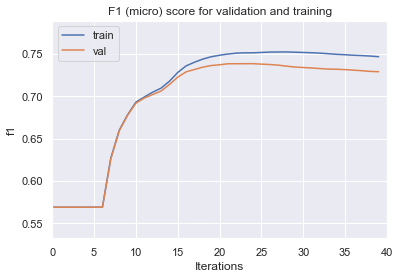

In [64]:
f1_plot = lgb.plot_metric(evals_result, metric='f1',
                          title='F1 (micro) score for validation and training')
wandb.log({'f1_score plot': wandb.Image(f1_plot)})
plt.show()

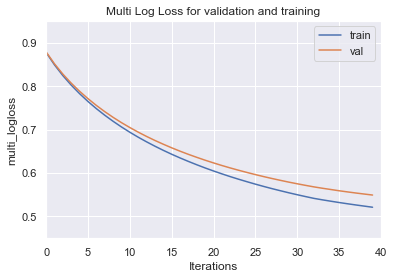

In [65]:
log_loss_plot = lgb.plot_metric(evals_result, metric='multi_logloss',
                title='Multi Log Loss for validation and training')
wandb.log({'multi logloss plot': wandb.Image(log_loss_plot)})

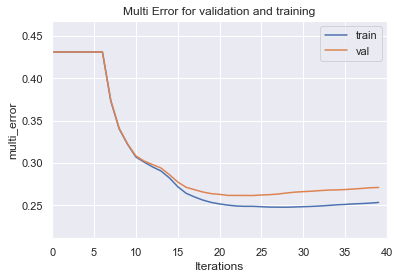

In [66]:
multierror_plot = lgb.plot_metric(evals_result, metric='multi_error',
                title='Multi Error for validation and training')
wandb.log({'multi error plot': wandb.Image(multierror_plot)})

In [67]:
run.finish()

train_multi_logloss,0.52111
train_multi_error,0.25346
train_f1,0.74654
val_multi_logloss,0.54925
val_multi_error,0.27119
val_f1,0.72881
_step,42
_runtime,88
_timestamp,1615823527


train_multi_logloss,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_multi_error,███████▆▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,▁▁▁▁▁▁▁▃▄▅▆▆▆▆▇▇▇███████████████████████
val_multi_logloss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_multi_error,███████▆▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▃▅▅▆▆▆▇▇▇████████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
